One way or another, machine learning is all about uncertainty. In supervised learning, we want to predict something unknown (the target) given something known (the features). Depending on our objective, we might attempt to predict the most likely value of the target. Or we might predict the value with the smallest expected distance from the target. And sometimes we wish not only to predict a specific value but to quantify our uncertainty. For example, given some features describing a patient, we might want to know how likely they are to suffer a heart attack in the next year. In unsupervised learning, we often care about uncertainty. To determine whether a set of measurements are anomalous, it helps to know how likely one is to observe values in a population of interest. Moreover, in reinforcement learning, we wish to develop agents that act intelligently in various environments. This requires reasoning about how an environment might be expected to change and what rewards one might expect to encounter in response to each of the available actions.

Probability is the mathematical field concerned with reasoning under uncertainty. Given a probabilistic model of some process, we can reason about the likelihood of various events. The use of probabilities to describe the frequencies of repeatable events (like coin tosses) is fairly uncontroversial. In fact, frequentist scholars adhere to an interpretation of probability that applies only to such repeatable events. By contrast Bayesian scholars use the language of probability more broadly to formalize our reasoning under uncertainty. Bayesian probability is characterized by two unique features: (i) assigning degrees of belief to non-repeatable events, e.g., what is the probability that the moon is made out of cheese?; and (ii) subjectivity—while Bayesian probability provides unambiguous rules for how one should update their beliefs in light of new evidence, it allows for different individuals to start off with different prior beliefs. Statistics helps us to reason backwards, starting off with collection and organization of data and backing out to what inferences we might draw about the process that generated the data. Whenever we analyze a dataset, hunting for patterns that we hope might characterize a broader population, we are employing statistical thinking. Most courses, majors, theses, careers, departments, companies, and institutions have been devoted to the study of probability and statistics. While this section only scratches the surface, we will provide the foundation that you need to begin building models.

In [1]:
%matplotlib inline
import random
import torch
from torch.distributions.multinomial import Multinomial
from d2l import torch as d2l

In [2]:
num_tosses = 100
heads = sum([random.random() > 0.5 for _ in range(100)])
tails = num_tosses - heads
print("heads, tails: ", [heads, tails])

heads, tails:  [49, 51]


More generally, we can simulate multiple draws from any variable with a finite number of possible outcomes (like the toss of a coin or roll of a die) by calling the multinomial function, setting the first argument to the number of draws and the second as a list of probabilities associated with each of the possible outcomes. To simulate ten tosses of a fair coin, we assign probability vector [0.5, 0.5], interpreting index 0 as heads and index 1 as tails. The function returns a vector with length equal to the number of possible outcomes (here, 2), where the first component tells us the number of occurrences of heads and the second component tells us the number of occurrences of tails.

In [3]:
fair_probs = torch.tensor([0.5, 0.5])
Multinomial(100, fair_probs).sample()

tensor([53., 47.])

Each time you run this sampling process, you will receive a new random value that may differ from the previous outcome. Dividing by the number of tosses gives us the frequency of each outcome in our data. Note that these frequencies, like the probabilities that they are intended to estimate, sum to 1

In [4]:
Multinomial(100, fair_probs).sample() / 100

tensor([0.4600, 0.5400])

Here, even though our simulated coin is fair (we set the probabilities [0.5, 0.5] ourselves), the counts of heads and tails may not be identical. That is because we only drew a finite number of samples. If we did not implement the simulation ourselves, and only saw the outcome, how would we know if the coin were slightly unfair or if the possible deviation from 1/2 was just an artifact of the small sample size? Let’s see what happens when we simulate 10000 tosses.

In [5]:
counts = Multinomial(10000, fair_probs).sample()
counts / 10000

tensor([0.4989, 0.5011])

In general, for averages of repeated events (like coin tosses), as the number of repetitions grows, our estimates are guaranteed to converge to the true underlying probabilities. The mathematical proof of this phenomenon is called the law of large numbers and the central limit theorem tells us that in many situations, as the sample size n grows, these errors should go down at a rate of 1/sqrt(n). Let’s get some more intuition by studying how our estimate evolves as we grow the number of tosses from 1 to 10000.

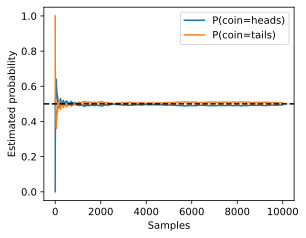

In [6]:
counts = Multinomial(1, fair_probs).sample((10000,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)
estimates = estimates.numpy()

d2l.set_figsize((4.5, 3.5))
d2l.plt.plot(estimates[:, 0], label=("P(coin=heads)"))
d2l.plt.plot(estimates[:, 1], label=("P(coin=tails)"))
d2l.plt.axhline(y=0.5, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Samples')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

Each solid curve corresponds to one of the two values of the coin and gives our estimated probability that the coin turns up that value after each group of experiments. The dashed black line gives the true underlying probability. As we get more data by conducting more experiments, the curves converge towards the true probability. You might already begin to see the shape of some of the more advanced questions that preoccupy statisticians: How quickly does this convergence happen? If we had already tested many coins manufactured at the same plant, how might we incorporate this information?

Note that there is a subtle difference between discrete random variables, like flips of a coin or tosses of a die, and continuous ones, like the weight and the height of a person sampled at random from the population. In this case we seldom really care about someone’s exact height. Moreover, if we took precise enough measurements, we would find that no two people on the planet have the exact same height. In fact, with fine enough measurements, you would never have the same height when you wake up and when you go to sleep. There’s little point in asking about the exact probability that someone is 1.801392782910287192 meters tall. Instead, we typically care more about being able to say whether someone’s height falls into a given interval, say between 1.79 and 1.81 meters. In these cases we work with probability densities. The height of exactly 1.80 meters has no probability, but nonzero density. To get out the probability assigned to an interval, we must take an integral of the density over that interval.

In machine learning, there are many things to be uncertain about! We can be uncertain about the value of a label given an input. We can be uncertain about the estimated value of a parameter. We can even be uncertain about whether data arriving at deployment is even from the same distribution as the training data.